# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [31]:
!pip install scikit-optimize

In [32]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Carpeta results ya existe


# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


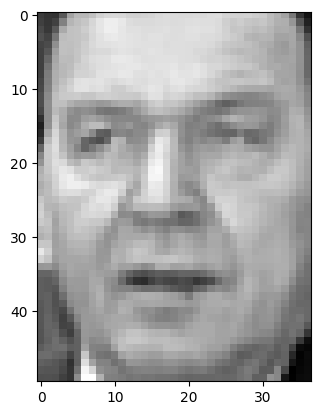

In [33]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [34]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [35]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression())],                # Pipeline1
    [('nor', MinMaxScaler()), ('cla', SGDClassifier())],                     # Pipeline2
    [('nor', MinMaxScaler()), ('cla', SVC())],                               # Pipeline3
    [('nor', MinMaxScaler()), ('cla', GaussianNB())],                        # Pipeline4
    [('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())],        # Pipeline5
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],              # Pipeline6
    [('nor', MinMaxScaler()), ('cla', LinearSVC(max_iter=5000))],            # Pipeline7
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier())],            # Pipeline8
]

parameters = [
    {'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3]},                             # Pipeline1 (LogisticRegression)
    {'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3]},                         # Pipeline2 (SGDClassifier)
    {'cla__C': [1,10,1e2,1e3,1e4], 'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]},# Pipeline3 (SVC)
    {},                                                                    # Pipeline4 (GaussianNB)
    {},                                                                    # Pipeline5 (LinearDiscriminantAnalysis)
    {'cla__n_neighbors': [3,5,7,9]},                                       # Pipeline6 (KNeighborsClassifier)
    {'cla__C': [0.01, 0.1, 1, 10]},                                        # Pipeline7 (LinearSVC)
    {'cla__n_estimators': [50, 100], 'cla__max_depth': [5, 10, None]},     # Pipeline8 (RandomForestClassifier)
]

label_models = [
    'MinMax_Logistic',
    'MinMax_SGD',
    'MinMax_SVCrbf',
    'MinMax_GaussianNB',
    'MinMax_LDA',
    'MinMax_KNN',
    'MinMax_LinearSVC',
    'MinMax_RandomForest'
]

models = []
filename = 'results/lfw_models'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1, len(steps)))
    grid_search = GridSearchCV(
        Pipeline(steps[i]),
        parameters[i],
        n_jobs=-1,
        cv=5,
        scoring='accuracy',
        refit=True,
        verbose=10
    )
    grid_search.fit(Xtrain, ytrain)
    models += [grid_search]
    joblib.dump(models, filename + ".pkl")

modelo 1/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/8
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/8
Fitting 5 folds for each of 25 candidates, totalling 125 fits
modelo 4/8
Fitting 5 folds for each of 1 candidates, totalling 5 fits
modelo 5/8
Fitting 5 folds for each of 1 candidates, totalling 5 fits
modelo 6/8
Fitting 5 folds for each of 4 candidates, totalling 20 fits
modelo 7/8
Fitting 5 folds for each of 4 candidates, totalling 20 fits
modelo 8/8
Fitting 5 folds for each of 6 candidates, totalling 30 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [36]:
# Recorrer todos los modelos y obtener el mejor score de validación cruzada
for i in range(len(models)):
    ind = models[i].cv_results_['mean_test_score'].argmax()
    print(f"Mejor score promedio para {label_models[i]}: {models[i].cv_results_['mean_test_score'][ind]:.3f}")

Mejor score promedio para MinMax_Logistic: 0.815
Mejor score promedio para MinMax_SGD: 0.768
Mejor score promedio para MinMax_SVCrbf: 0.804
Mejor score promedio para MinMax_GaussianNB: 0.376
Mejor score promedio para MinMax_LDA: 0.707
Mejor score promedio para MinMax_KNN: 0.562
Mejor score promedio para MinMax_LinearSVC: 0.821
Mejor score promedio para MinMax_RandomForest: 0.599


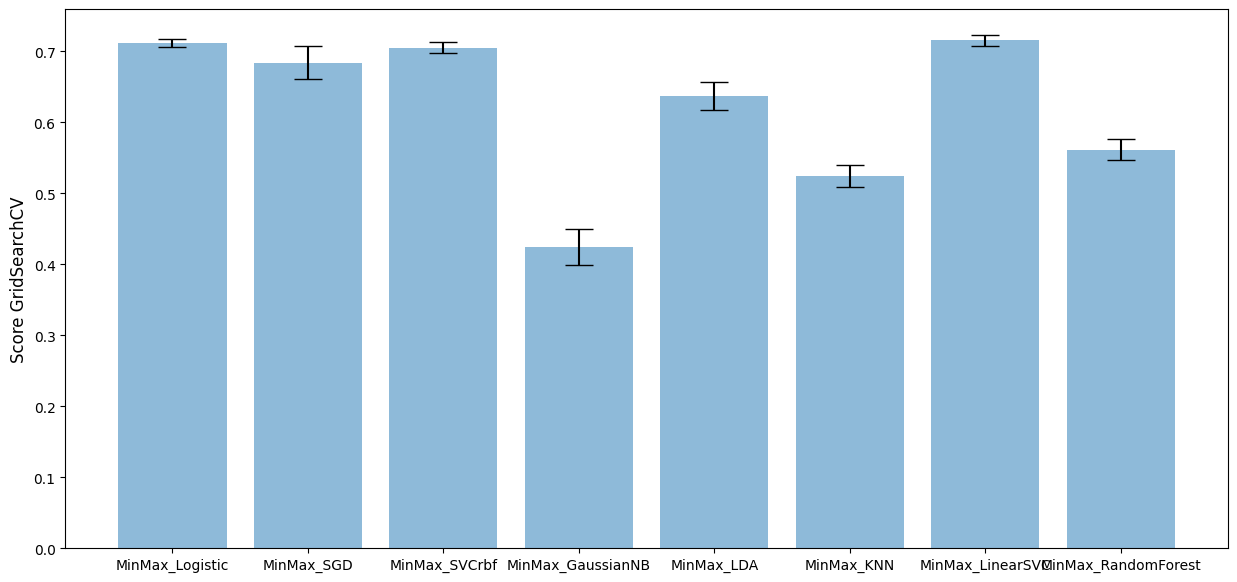

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_GaussianNB', 'MinMax_LDA', 'MinMax_KNN', 'MinMax_LinearSVC', 'MinMax_RandomForest']
[[0.712 0.684 0.705 0.424 0.638 0.524 0.716 0.561]
 [0.005 0.023 0.008 0.025 0.02  0.016 0.008 0.015]]


In [48]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.figure(figsize=(15, 7))
plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV',fontsize=12)
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/8)


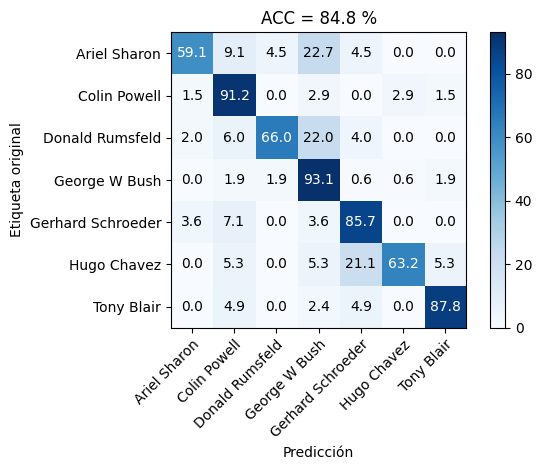

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/8)


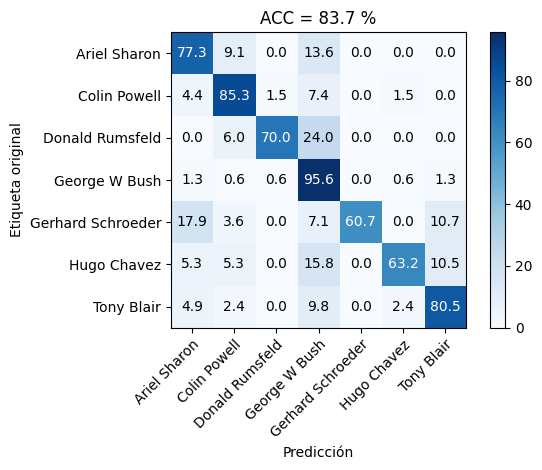

                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.77      0.65        22
     Colin Powell       0.87      0.85      0.86        68
  Donald Rumsfeld       0.95      0.70      0.80        50
    George W Bush       0.84      0.96      0.89       159
Gerhard Schroeder       1.00      0.61      0.76        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.82      0.80      0.81        41

         accuracy                           0.84       387
        macro avg       0.83      0.76      0.78       387
     weighted avg       0.85      0.84      0.84       387

Evaluando modelo MinMax_SVCrbf (3/8)


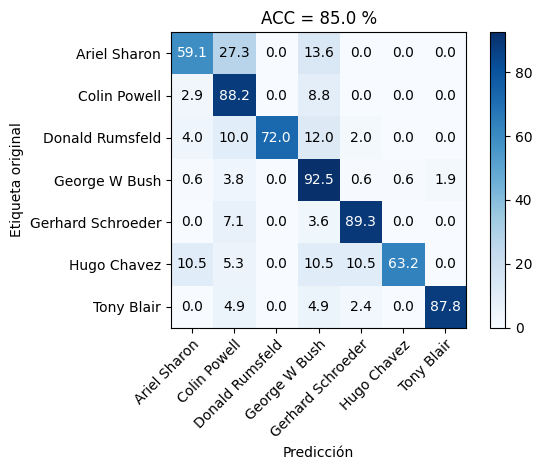

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387

Evaluando modelo MinMax_GaussianNB (4/8)


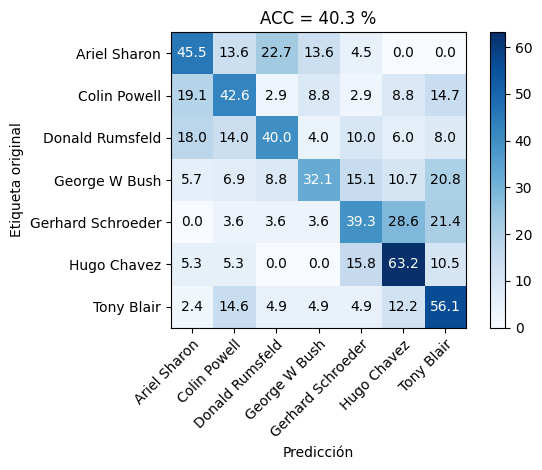

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo MinMax_LDA (5/8)


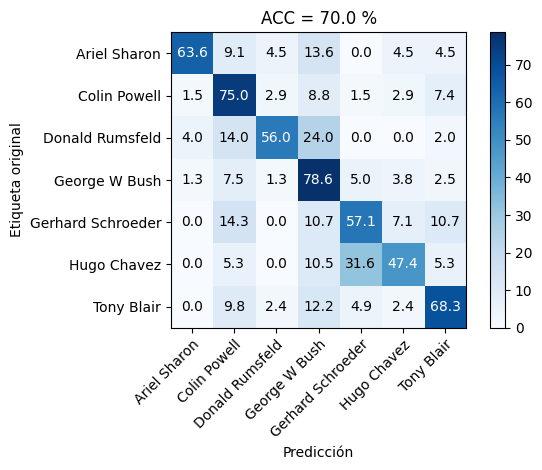

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluando modelo MinMax_KNN (6/8)


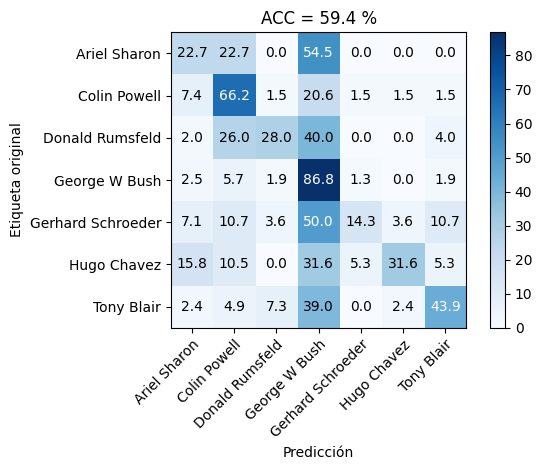

                   precision    recall  f1-score   support

     Ariel Sharon       0.24      0.23      0.23        22
     Colin Powell       0.57      0.66      0.61        68
  Donald Rumsfeld       0.64      0.28      0.39        50
    George W Bush       0.63      0.87      0.73       159
Gerhard Schroeder       0.50      0.14      0.22        28
      Hugo Chavez       0.67      0.32      0.43        19
       Tony Blair       0.64      0.44      0.52        41

         accuracy                           0.59       387
        macro avg       0.55      0.42      0.45       387
     weighted avg       0.59      0.59      0.56       387

Evaluando modelo MinMax_LinearSVC (7/8)


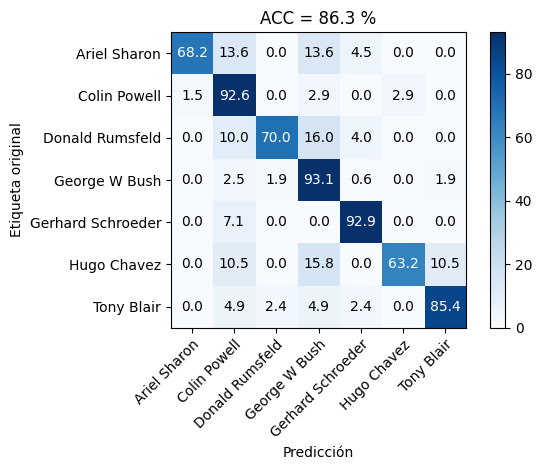

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.68      0.79        22
     Colin Powell       0.78      0.93      0.85        68
  Donald Rumsfeld       0.90      0.70      0.79        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.84      0.93      0.88        28
      Hugo Chavez       0.86      0.63      0.73        19
       Tony Blair       0.88      0.85      0.86        41

         accuracy                           0.86       387
        macro avg       0.87      0.81      0.83       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo MinMax_RandomForest (8/8)


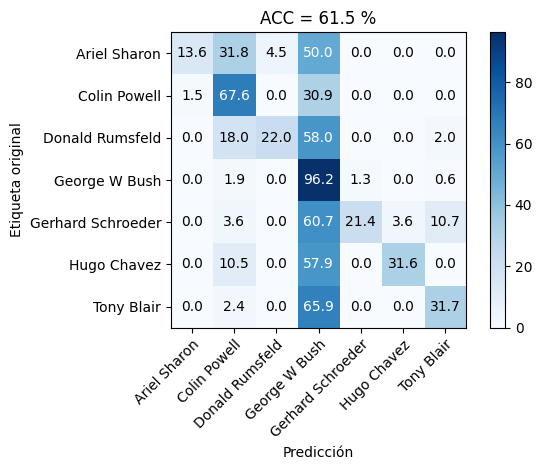

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.14      0.23        22
     Colin Powell       0.67      0.68      0.67        68
  Donald Rumsfeld       0.92      0.22      0.35        50
    George W Bush       0.57      0.96      0.71       159
Gerhard Schroeder       0.75      0.21      0.33        28
      Hugo Chavez       0.86      0.32      0.46        19
       Tony Blair       0.72      0.32      0.44        41

         accuracy                           0.61       387
        macro avg       0.75      0.41      0.46       387
     weighted avg       0.68      0.61      0.56       387



In [38]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/8)


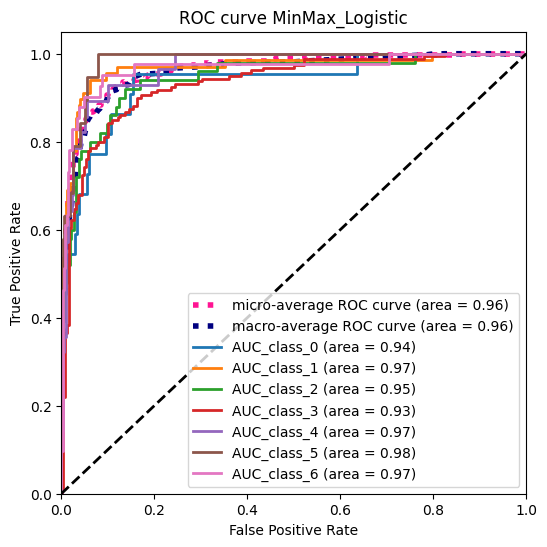

Evaluando modelo MinMax_SGD (2/8)


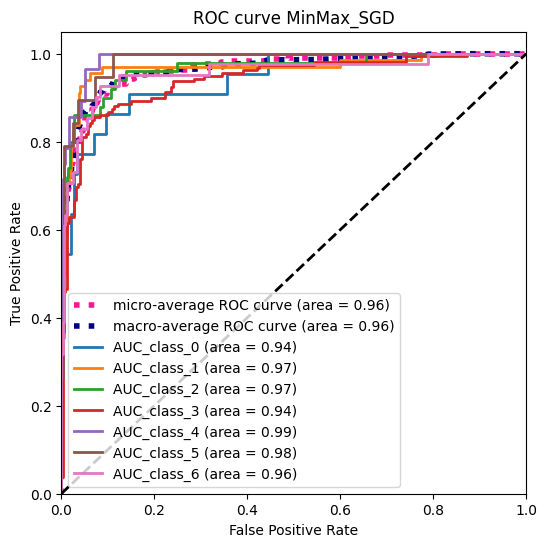

Evaluando modelo MinMax_SVCrbf (3/8)


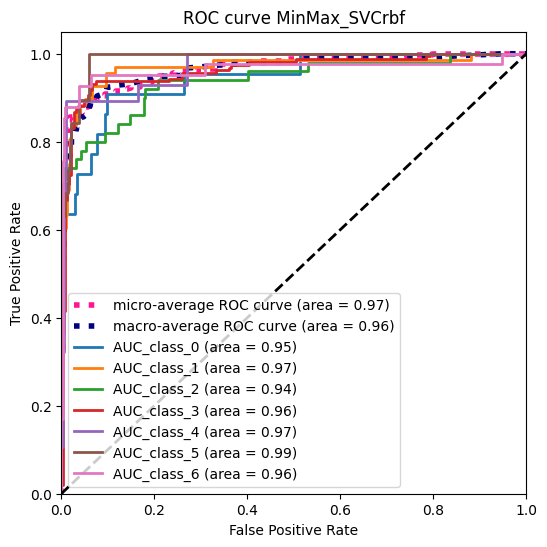

Evaluando modelo MinMax_GaussianNB (4/8)


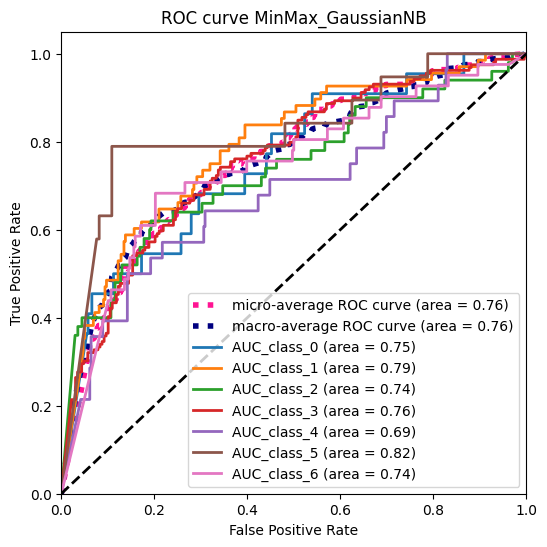

Evaluando modelo MinMax_LDA (5/8)


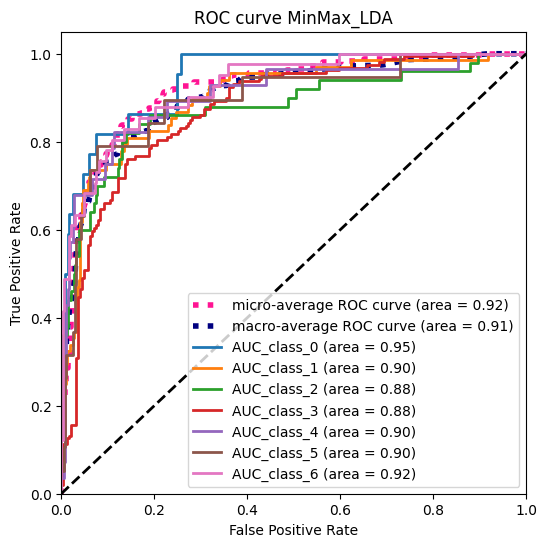

Evaluando modelo MinMax_KNN (6/8)


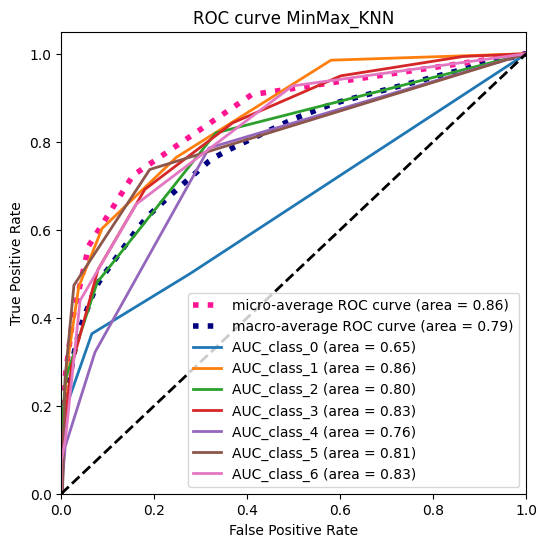

Evaluando modelo MinMax_LinearSVC (7/8)


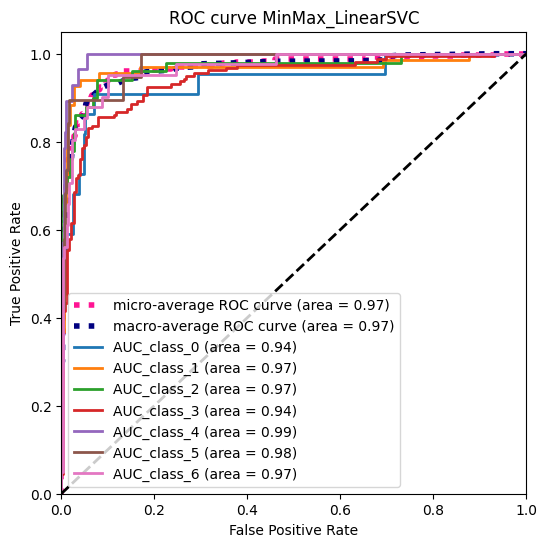

Evaluando modelo MinMax_RandomForest (8/8)


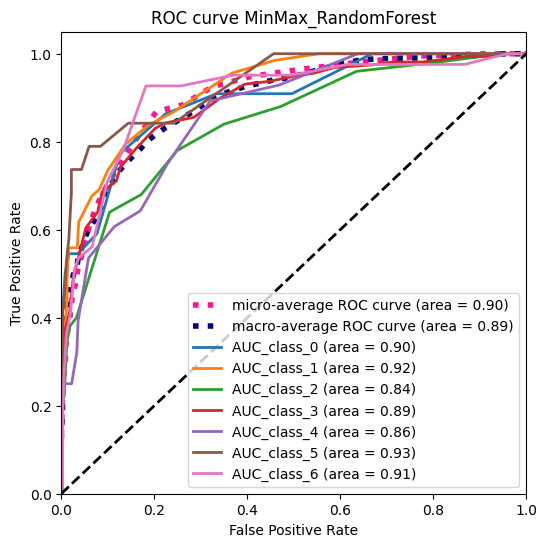

In [39]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i+1, len(my_model_loaded)))
    # Obtener el mejor estimador
    estimator = my_model_loaded[i].best_estimator_
    # Obtener la función de decisión o la probabilidad según el modelo
    if hasattr(estimator, "decision_function"):
        ytest_score = estimator.decision_function(Xtest)
    elif hasattr(estimator, "predict_proba"):
        ytest_score = estimator.predict_proba(Xtest)
    else:
        raise AttributeError(f"El modelo {label_models[i]} no tiene decision_function ni predict_proba.")
    # Calcular las curvas ROC
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b, ytest_score)
    roc_auc_mc(roc_auc, fpr, tpr, n_classes, 'ROC curve ' + label_models[i], path_img)

# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


# Modelos de Clasificación y Problemas de Optimización

## 1. Naive Bayes (GaussianNB)
**Descripción**:  
Clasificador probabilístico basado en el teorema de Bayes con supuesto de independencia entre características.  
**Problema de optimización**:  
No tiene parámetros optimizables en el sentido tradicional. Los parámetros (medias y varianzas) se calculan directamente mediante máxima verosimilitud:  
$$\hat{\mu}_{y,i} = \frac{\sum_{j=1}^{n} x_{j,i} \cdot \mathbb{I}(y_j = y)}{\sum_{j=1}^{n} \mathbb{I}(y_j = y)}$$  
$$\hat{\sigma}^2_{y,i} = \frac{\sum_{j=1}^{n} (x_{j,i} - \hat{\mu}_{y,i})^2 \cdot \mathbb{I}(y_j = y)}{\sum_{j=1}^{n} \mathbb{I}(y_j = y)}$$  
**Hiperparámetros clave**:  
- `var_smoothing`: Parámetro de estabilización para evitar varianzas cero (fijado en 1e-9 en nuestro caso)

---

## 2. SGDClassifier
**Descripción**:  
Clasificador lineal que utiliza Descenso de Gradiente Estocástico para optimización.  
**Problema de optimización**:  
Minimiza función de pérdida regularizada:  
$$\min_{w} \frac{1}{n} \sum_{i=1}^{n} L(y_i, w^T x_i) + \alpha R(w)$$  
Donde:
- $L$: Función de pérdida (hinge, log, etc.)
- $R$: Término de regularización (L1, L2, ElasticNet)  
**Hiperparámetros clave**:  
- `alpha`: Parámetro de regularización (espacio log-uniforme: 1e-3 a 1e3)
- `loss`: Función de pérdida (hinge, log_loss, etc.)
- `penalty`: Tipo de regularización (L1, L2, elasticnet)

---

## 3. LogisticRegression
**Descripción**:  
Modelo de regresión logística para clasificación binaria/multiclase.  
**Problema de optimización**:  
Minimiza la pérdida logística regularizada:  
$$\min_{w} C \sum_{i=1}^{n} \log(1 + e^{-y_i w^T x_i}) + ||w||_2^2$$  
**Hiperparámetros clave**:  
- `C`: Inverso de fuerza de regularización (espacio log-uniforme: 1e-3 a 1e3)
- `penalty`: Tipo de penalización (l1, l2, elasticnet, none)
- `solver`: Algoritmo de optimización (lbfgs, liblinear, newton-cg)

---

## 4. LinearDiscriminantAnalysis (LDA)
**Descripción**:  
Método de proyección lineal que maximiza la separación entre clases.  
**Problema de optimización**:  
Maximiza el cociente entre varianza inter-clase e intra-clase:  
$$\max_{w} \frac{w^T S_b w}{w^T S_w w}$$  
Donde:
- $S_b$: Matriz de dispersión entre clases
- $S_w$: Matriz de dispersión dentro de clases  
**Hiperparámetros clave**:  
- `solver`: Algoritmo para descomposición (svd, lsqr, eigen)
- `shrinkage`: Parámetro de regularización para matrices de covarianza (auto o float)

---

## 5. KNeighborsClassifier
**Descripción**:  
Clasificador basado en votación de vecinos más cercanos.  
**Problema de optimización**:  
No tiene optimización paramétrica. La predicción es por votación mayoritaria:  
$$\hat{y} = \text{moda}\left( \{ y_i | i \in N_k(x) \} \right)$$  
Donde $N_k(x)$ son los k vecinos más cercanos a x.  
**Hiperparámetros clave**:  
- `n_neighbors`: Número de vecinos (espacio entero: 3-15)
- `weights`: Función de peso (uniform, distance)
- `metric`: Métrica de distancia (euclidean, manhattan, minkowski)

---

## 6. LinearSVC
**Descripción**:  
Implementación lineal de Máquinas de Vectores de Soporte.  
**Problema de optimización**:  
Minimiza la pérdida hinge regularizada:  
$$\min_{w} \frac{1}{2}||w||^2 + C \sum_{i=1}^{n} \max(0, 1 - y_i w^T x_i)$$  
**Hiperparámetros clave**:  
- `C`: Parámetro de regularización (espacio log-uniforme: 0.01 a 10)
- `loss`: Función de pérdida (hinge, squared_hinge)
- `penalty`: Tipo de penalización (l1, l2)

---

## 7. SVC (Support Vector Classification)
**Descripción**:  
Máquinas de Vectores de Soporte con kernel no lineal.  
**Problema de optimización**:  
Optimización dual del problema SVM:  
$$\max_{\alpha} \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j K(x_i, x_j)$$  
Sujeto a:  
$$0 \leq \alpha_i \leq C \quad \text{y} \quad \sum_{i} \alpha_i y_i = 0$$  
**Hiperparámetros clave**:  
- `C`: Parámetro de regularización (espacio log-uniforme: 1 a 1e4)
- `gamma`: Coeficiente del kernel (espacio log-uniforme: 1e-3 a 10)
- `kernel`: Tipo de kernel (rbf, poly, sigmoid)

---

## 8. RandomForestClassifier
**Descripción**:  
Ensemble de árboles de decisión con bagging.  
**Problema de optimización**:  
Construcción greedy de múltiples árboles mediante:  
1. Muestreo bootstrap de datos
2. Selección óptima de características en cada nodo:  
$$\max_{f,t} IG(D, f, t) = H(D) - \sum_{child} \frac{|D_{child}|}{|D|} H(D_{child})$$  
**Hiperparámetros clave**:  
- `n_estimators`: Número de árboles (espacio entero: 50-200)
- `max_depth`: Profundidad máxima (espacio entero: 5-30)
- `max_features`: Número de características por división (auto, sqrt, log2)
- `min_samples_split`: Mínimo muestras para dividir nodo

---

## Objetivo Común de Optimización
Para todos los modelos, la búsqueda bayesiana optimiza la métrica combinada:  
$$\text{Score} = \frac{\text{Accuracy} + \text{F1} + \text{AUC}}{3}$$  
Esta métrica balancea precisión global, equilibrio entre precisión/recall (F1) y capacidad de discriminación (AUC).

In [42]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV  # Cambio a optimización bayesiana
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
import numpy as np
import joblib

# 1. Definir scorer personalizado (combinación de acc, f1 y AUC)
def combined_scorer(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')  # Para multiclase
    try:
        auc = roc_auc_score(y_true, y_pred, multi_class='ovo')
    except:
        auc = 0.5  # Valor neutral si hay error
    return np.mean([acc, f1, auc])  # Promedio simple

custom_scorer = make_scorer(combined_scorer)

# Pipeline y parámetros originales
steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression())],               # Pipeline1
    [('nor', MinMaxScaler()), ('cla', SGDClassifier())],                    # Pipeline2
    [('nor', MinMaxScaler()), ('cla', SVC(probability=True))],              # Pipeline3 (habilitar probabilidad para AUC)
    [('nor', MinMaxScaler()), ('cla', GaussianNB())],                       # Pipeline4
    [('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())],       # Pipeline5
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],             # Pipeline6
    [('nor', MinMaxScaler()), ('cla', LinearSVC(max_iter=5000))],           # Pipeline7
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier())],           # Pipeline8
]

# Espacios de búsqueda para BayesSearchCV (sintaxis de skopt)
bayes_parameters = [
    # Pipeline1 (LogisticRegression)
    {'cla__C': Real(1e-3, 1e3, prior='log-uniform')},
    # Pipeline2 (SGDClassifier)
    {'cla__alpha': Real(1e-3, 1e3, prior='log-uniform')},
    # Pipeline3 (SVC)
    {
        'cla__C': Real(1, 1e4, prior='log-uniform'),
        'cla__gamma': Real(1e-3, 10, prior='log-uniform')
    },
    # Pipeline4 (GaussianNB) - Espacio dummy
    {'cla__var_smoothing': Categorical([1e-9])},  # Valor por defecto
    # Pipeline5 (LinearDiscriminantAnalysis) - Espacio dummy
    {'cla__solver': Categorical(['svd'])},        # Valor por defecto
    # Pipeline6 (KNeighborsClassifier)
    {'cla__n_neighbors': Integer(3, 15)},         # Rango amplio de vecinos
    # Pipeline7 (LinearSVC)
    {'cla__C': Real(0.01, 10, prior='log-uniform')},
    # Pipeline8 (RandomForestClassifier)
    {
        'cla__n_estimators': Integer(50, 200),   # Rango más amplio
        'cla__max_depth': Integer(5, 30)          # Evita None para simplificar
    }
]

label_models = [
    'MinMax_Logistic',
    'MinMax_SGD',
    'MinMax_SVCrbf',
    'MinMax_GaussianNB',
    'MinMax_LDA',
    'MinMax_KNN',
    'MinMax_LinearSVC',
    'MinMax_RandomForest'
]

models = []
filename = 'results/lfw_models'
n_iterations = 50  # Iteraciones para optimización bayesiana

for i in range(len(steps)):
    print(f'Entrenando modelo {i+1}/{len(steps)}: {label_models[i]}')

    # Configuración de BayesSearchCV
    bayes_search = BayesSearchCV(
        estimator=Pipeline(steps[i]),
        search_spaces=bayes_parameters[i],
        n_iter=n_iterations,
        cv=5,
        scoring=custom_scorer,  # Scorer personalizado
        refit=True,
        verbose=10,
        n_jobs=-1,
        random_state=42
    )

    bayes_search.fit(Xtrain, ytrain)
    models.append(bayes_search)
    joblib.dump(models, filename + ".pkl")

Entrenando modelo 1/8: MinMax_Logistic
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds f

In [43]:
# Recorrer todos los modelos y obtener el mejor score de validación cruzada
for i in range(len(models)):
    ind = models[i].cv_results_['mean_test_score'].argmax()
    print(f"Mejor score promedio para {label_models[i]}: {models[i].cv_results_['mean_test_score'][ind]:.3f}")

Mejor score promedio para MinMax_Logistic: 0.712
Mejor score promedio para MinMax_SGD: 0.684
Mejor score promedio para MinMax_SVCrbf: 0.705
Mejor score promedio para MinMax_GaussianNB: 0.424
Mejor score promedio para MinMax_LDA: 0.638
Mejor score promedio para MinMax_KNN: 0.524
Mejor score promedio para MinMax_LinearSVC: 0.716
Mejor score promedio para MinMax_RandomForest: 0.561


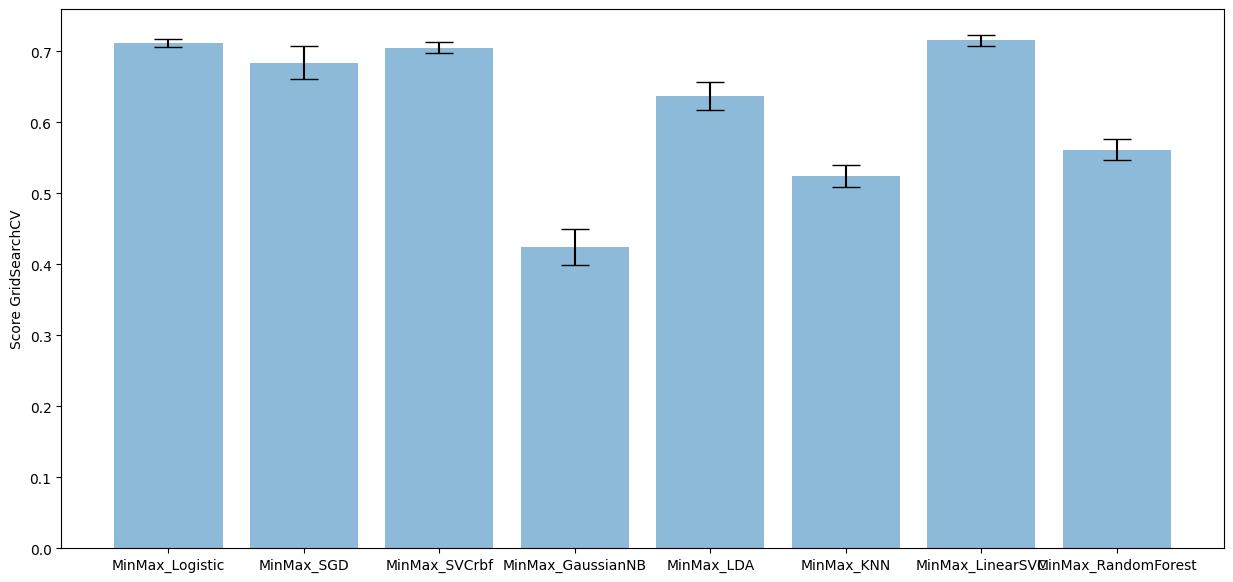

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf', 'MinMax_GaussianNB', 'MinMax_LDA', 'MinMax_KNN', 'MinMax_LinearSVC', 'MinMax_RandomForest']
[[0.712 0.684 0.705 0.424 0.638 0.524 0.716 0.561]
 [0.005 0.023 0.008 0.025 0.02  0.016 0.008 0.015]]


In [49]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.figure(figsize=(15, 7))
plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

Evaluando modelo MinMax_Logistic (1/8)


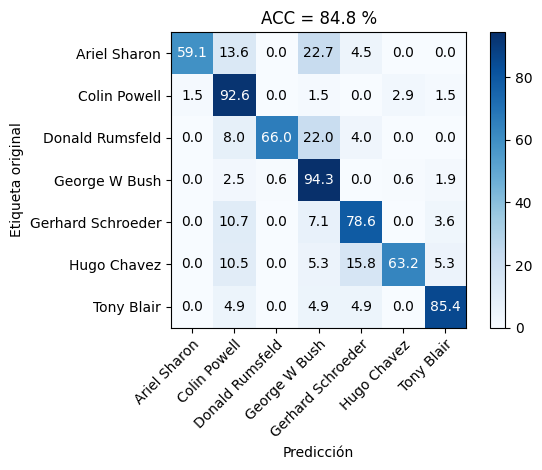

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.59      0.72        22
     Colin Powell       0.78      0.93      0.85        68
  Donald Rumsfeld       0.97      0.66      0.79        50
    George W Bush       0.87      0.94      0.91       159
Gerhard Schroeder       0.73      0.79      0.76        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.85      0.85      0.85        41

         accuracy                           0.85       387
        macro avg       0.85      0.77      0.80       387
     weighted avg       0.86      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/8)


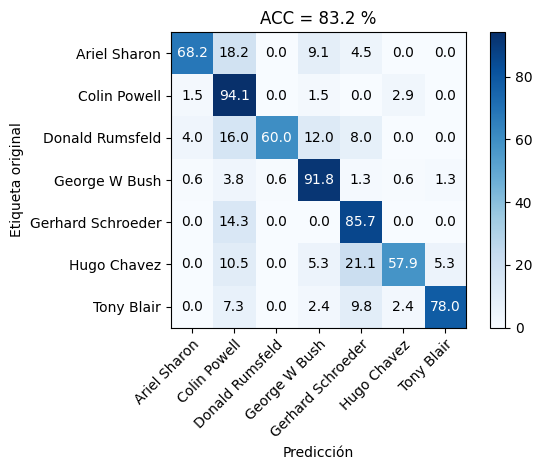

                   precision    recall  f1-score   support

     Ariel Sharon       0.79      0.68      0.73        22
     Colin Powell       0.70      0.94      0.81        68
  Donald Rumsfeld       0.97      0.60      0.74        50
    George W Bush       0.93      0.92      0.92       159
Gerhard Schroeder       0.62      0.86      0.72        28
      Hugo Chavez       0.73      0.58      0.65        19
       Tony Blair       0.91      0.78      0.84        41

         accuracy                           0.83       387
        macro avg       0.81      0.77      0.77       387
     weighted avg       0.85      0.83      0.83       387

Evaluando modelo MinMax_SVCrbf (3/8)


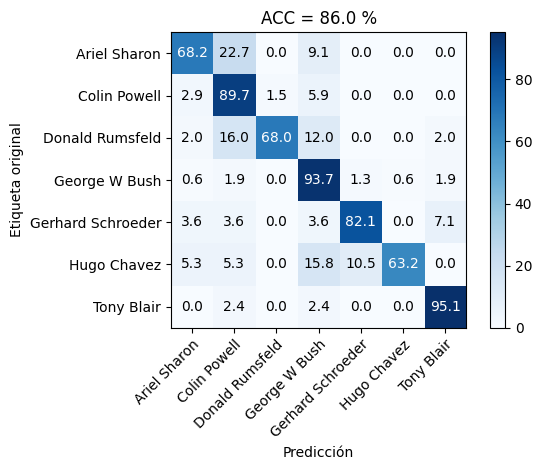

                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.68      0.70        22
     Colin Powell       0.76      0.90      0.82        68
  Donald Rumsfeld       0.97      0.68      0.80        50
    George W Bush       0.90      0.94      0.92       159
Gerhard Schroeder       0.85      0.82      0.84        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.87      0.95      0.91        41

         accuracy                           0.86       387
        macro avg       0.86      0.80      0.82       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo MinMax_GaussianNB (4/8)


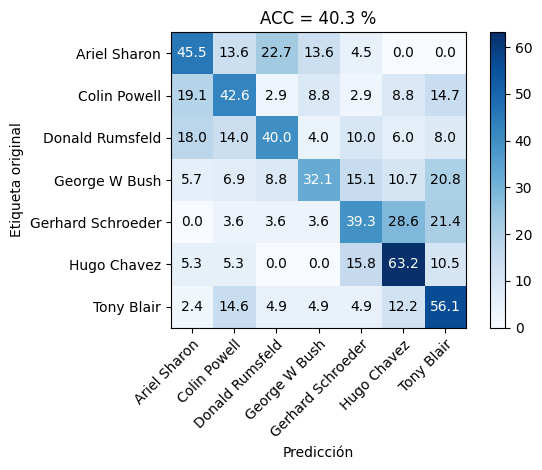

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387

Evaluando modelo MinMax_LDA (5/8)


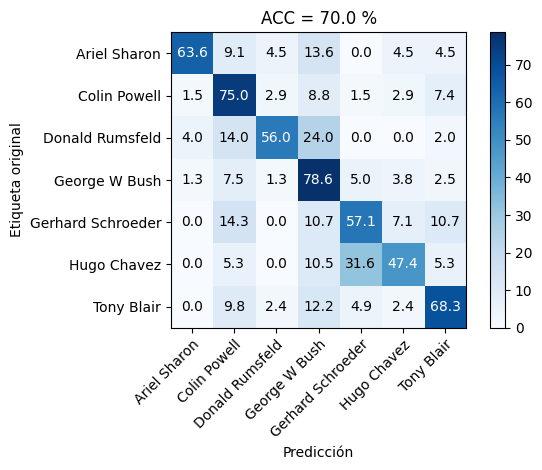

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387

Evaluando modelo MinMax_KNN (6/8)


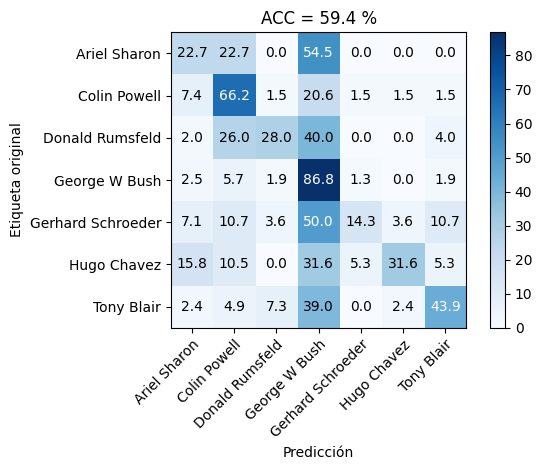

                   precision    recall  f1-score   support

     Ariel Sharon       0.24      0.23      0.23        22
     Colin Powell       0.57      0.66      0.61        68
  Donald Rumsfeld       0.64      0.28      0.39        50
    George W Bush       0.63      0.87      0.73       159
Gerhard Schroeder       0.50      0.14      0.22        28
      Hugo Chavez       0.67      0.32      0.43        19
       Tony Blair       0.64      0.44      0.52        41

         accuracy                           0.59       387
        macro avg       0.55      0.42      0.45       387
     weighted avg       0.59      0.59      0.56       387

Evaluando modelo MinMax_LinearSVC (7/8)


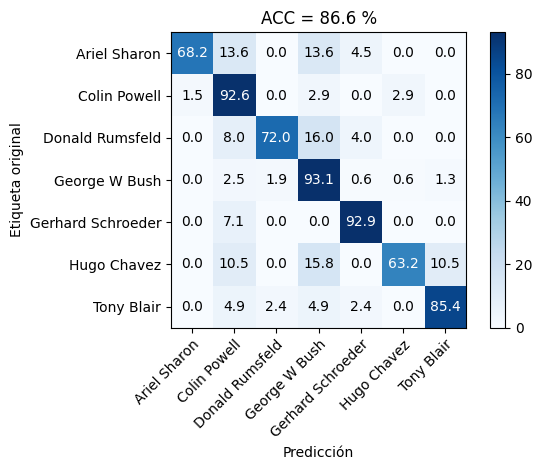

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.68      0.79        22
     Colin Powell       0.79      0.93      0.85        68
  Donald Rumsfeld       0.90      0.72      0.80        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.84      0.93      0.88        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.90      0.85      0.88        41

         accuracy                           0.87       387
        macro avg       0.86      0.81      0.83       387
     weighted avg       0.87      0.87      0.86       387

Evaluando modelo MinMax_RandomForest (8/8)


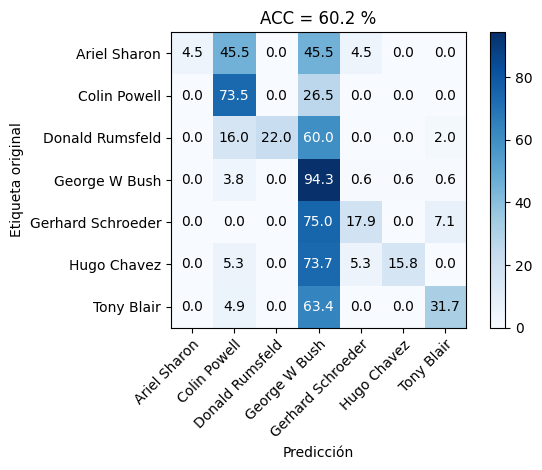

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.05      0.09        22
     Colin Powell       0.65      0.74      0.69        68
  Donald Rumsfeld       1.00      0.22      0.36        50
    George W Bush       0.56      0.94      0.70       159
Gerhard Schroeder       0.62      0.18      0.28        28
      Hugo Chavez       0.75      0.16      0.26        19
       Tony Blair       0.76      0.32      0.45        41

         accuracy                           0.60       387
        macro avg       0.76      0.37      0.40       387
     weighted avg       0.69      0.60      0.54       387



In [45]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


Evaluando modelo MinMax_Logistic (1/8)


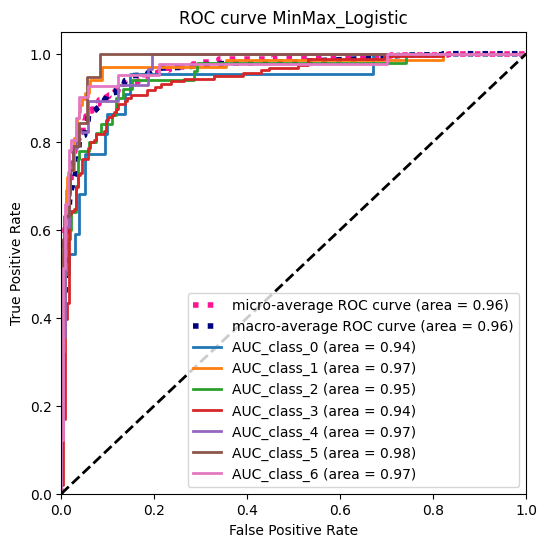

Evaluando modelo MinMax_SGD (2/8)


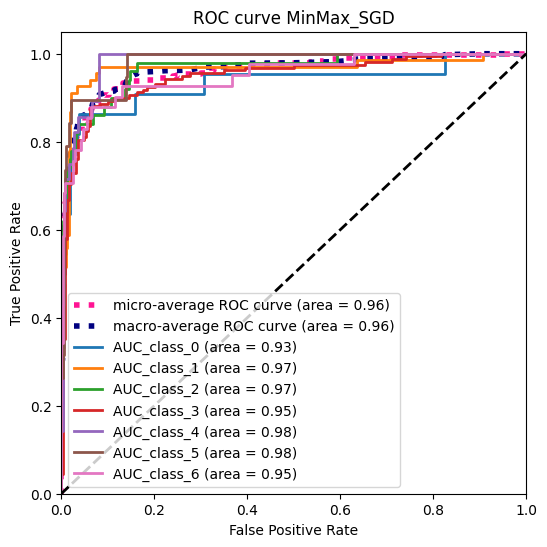

Evaluando modelo MinMax_SVCrbf (3/8)


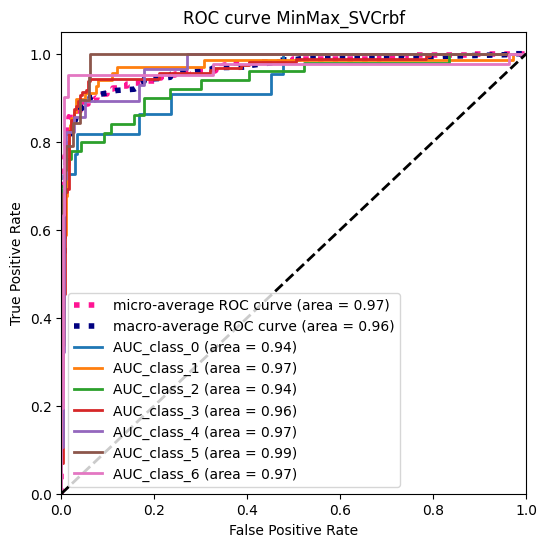

Evaluando modelo MinMax_GaussianNB (4/8)


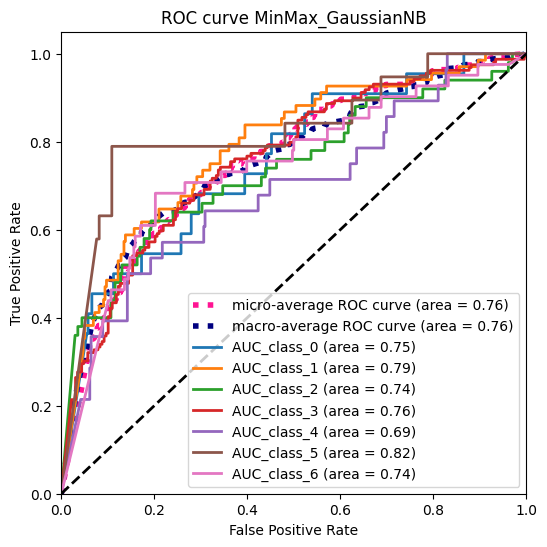

Evaluando modelo MinMax_LDA (5/8)


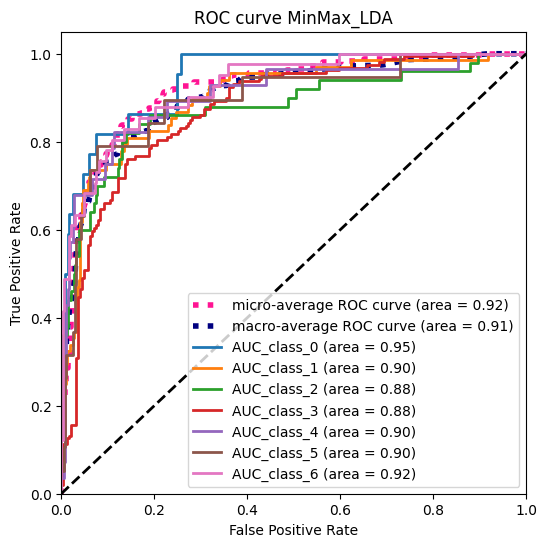

Evaluando modelo MinMax_KNN (6/8)


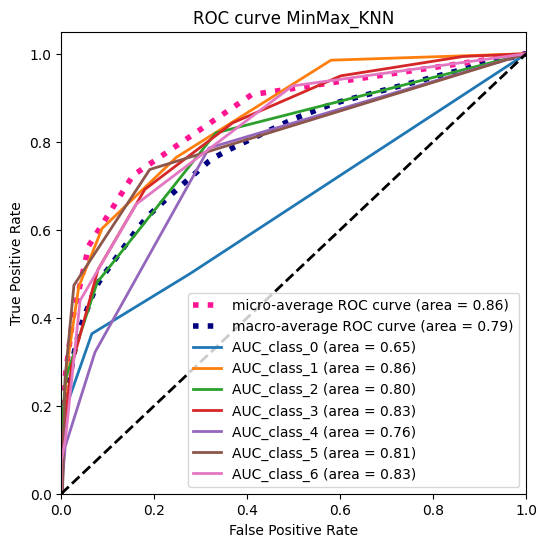

Evaluando modelo MinMax_LinearSVC (7/8)


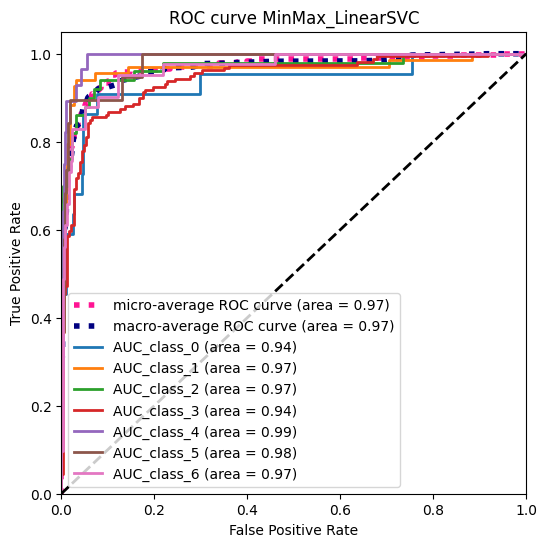

Evaluando modelo MinMax_RandomForest (8/8)


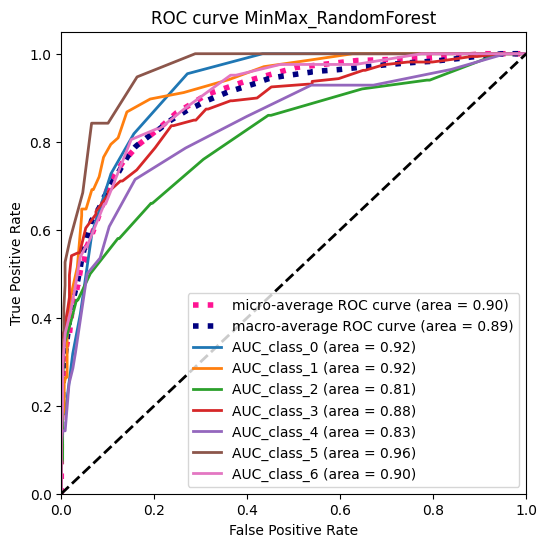

In [46]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i+1, len(my_model_loaded)))
    # Obtener el mejor estimador
    estimator = my_model_loaded[i].best_estimator_
    # Obtener la función de decisión o la probabilidad según el modelo
    if hasattr(estimator, "decision_function"):
        ytest_score = estimator.decision_function(Xtest)
    elif hasattr(estimator, "predict_proba"):
        ytest_score = estimator.predict_proba(Xtest)
    else:
        raise AttributeError(f"El modelo {label_models[i]} no tiene decision_function ni predict_proba.")
    # Calcular las curvas ROC
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b, ytest_score)
    roc_auc_mc(roc_auc, fpr, tpr, n_classes, 'ROC curve ' + label_models[i], path_img)